In [85]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Clinical data/clinical_data.csv", index_col=0)

# Separate categorical and numerical
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

# Impute missing values
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
df[num_cols] = SimpleImputer(strategy="mean").fit_transform(df[num_cols])

for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Combine and scale
scaler = MaxAbsScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

scaled

,histology_diagnosis,age,sex,race,participant_country,tumor_site,tumor_size_cm,tumor_necrosis,lymph_vascular_invasion,perineural_invasion,...,residual_tumor,tumor_stage_pathological,additiol_pathologic_findings,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death
case_id,,,,,,,,,,,,,,,,,,,,,
C3L-00017,1.0,0.811765,1.0,1.0,1.000000,0.50,0.600000,0.0,0.5,1.0,...,1.000000,0.4,0.50,0.618809,0.00,0.0,0.312317,1.0,1.0,0.875
C3L-00102,1.0,0.494118,1.0,1.0,1.000000,0.50,0.400000,0.0,1.0,1.0,...,0.000000,0.8,0.10,0.587606,0.25,0.8,0.182551,0.0,0.0,0.875
C3L-00189,1.0,0.800000,0.0,1.0,0.090909,0.50,0.360000,0.0,0.5,1.0,...,0.333333,0.6,1.00,0.747982,0.00,0.2,0.758798,0.0,0.0,0.875
C3L-00277,1.0,0.811765,1.0,1.0,0.545455,1.00,0.666667,0.0,0.5,1.0,...,0.666667,0.6,0.30,0.523674,0.00,0.8,0.447214,0.0,1.0,0.875
C3L-00401,1.0,0.729412,0.0,1.0,0.090909,0.00,0.373333,0.0,1.0,1.0,...,0.000000,0.6,0.05,0.489199,0.00,0.8,0.900293,1.0,0.0,0.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-04119,1.0,0.635294,1.0,1.0,0.181818,1.00,0.400000,0.0,0.5,1.0,...,0.000000,0.6,0.10,0.516256,1.00,0.8,0.223607,0.0,0.0,0.875
C3N-04126,1.0,0.494118,1.0,1.0,0.181818,0.50,0.466667,0.0,1.0,1.0,...,0.000000,0.8,0.10,0.531966,1.00,0.8,0.255132,0.0,0.0,0.875
C3N-04282,1.0,0.882353,1.0,1.0,0.636364,0.50,0.533333,1.0,1.0,1.0,...,0.333333,1.0,1.00,0.349116,0.00,0.6,0.222141,0.0,0.0,0.875


In [86]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

scores = []
for k in range(2, 10):
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(scaled)
    score = silhouette_score(scaled, labels)
    scores.append((k, score))

print(scores)

[(2, 0.15994729984513845), (3, 0.10901825368639173), (4, 0.0945354389945992), (5, 0.11604044461213657), (6, 0.1206346408682817), (7, 0.11386276550568453), (8, 0.12200828662504552), (9, 0.11971643128815554)]


In [ ]:
from sklearn.cluster import SpectralClustering

n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
labels = spectral.fit_predict(scaled)

In [88]:
scaled['cluster'] = labels
summary = scaled.groupby('cluster').agg(['mean', 'std', 'count'])
summary

histology_diagnosis                       age                    sex  \
                       mean       std count      mean       std count   mean   
cluster                                                                        
0                      0.97  0.171447   100  0.750000  0.132686   100  0.490   
1                      0.95  0.220721    40  0.770588  0.126092    40  0.625   

                          race  ... follow_up_days vital_status            \
              std count   mean  ...          count         mean       std   
cluster                         ...                                         
0        0.502418   100  0.990  ...            100         0.35  0.479372   
1        0.490290    40  0.975  ...             40         0.60  0.496139   

              is_this_patient_lost_to_follow_up                  \
        count                              mean       std count   
cluster                                                           
0         100                              0.30  0.460566   100   
1          40                              0.35  0.483046    40   

        cause_of_death                  
                  mean       std count  
cluster                                 
0             0.837500  0.192587   100  
1             0.884375  0.059293    40  

[2 rows x 72 columns]

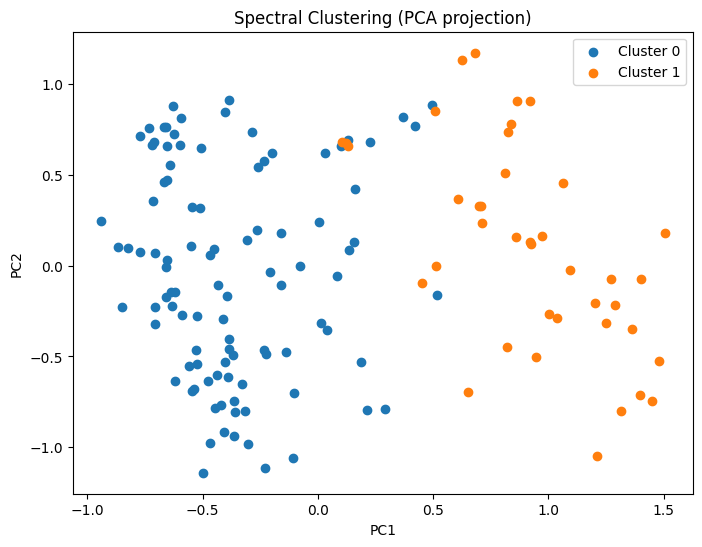

In [89]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled.drop(columns=['cluster']))

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(reduced[labels==i,0], reduced[labels==i,1], label=f"Cluster {i}")
plt.legend()
plt.title("Spectral Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


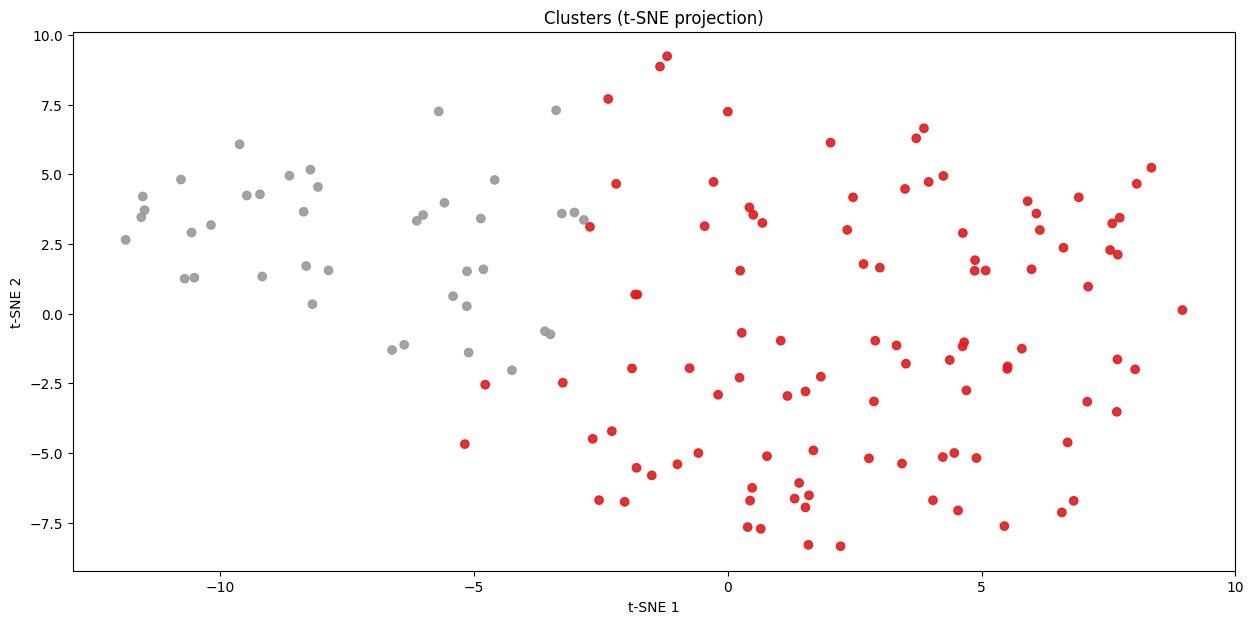

In [90]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled.drop(columns=['cluster'])) 

plt.figure(figsize=(15,7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1', alpha=0.9)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters (t-SNE projection)')

plt.savefig(r'images/t-SNE.png', transparent=True, bbox_inches='tight')